In [45]:
import argparse
import logging.config
import os
from collections import defaultdict

from dotenv import load_dotenv

from rescueclip.logging_config import LOGGING_CONFIG

logging.config.dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
from pathlib import Path
import matplotlib.pyplot as plt
import time

import numpy as np
from typing import cast, Sequence, List, Any, Literal
import weaviate
from tqdm import tqdm
from weaviate.classes.query import Filter, MetadataQuery
from weaviate.collections.classes.types import Properties, WeaviateProperties
from weaviate.collections.classes.internal import Object
from weaviate.util import generate_uuid5, get_vector

from rescueclip import cuhk
from rescueclip.cuhk import SetNumToImagesMap
from rescueclip.ml_model import (
    CollectionConfig,
    CUHK_Apple_Collection,
    CUHK_Google_Siglip_Base_Patch16_224_Collection,
    CUHK_Google_Siglip_SO400M_Patch14_384_Collection,
    CUHK_laion_CLIP_ViT_bigG_14_laion2B_39B_b160k_Collection,
    CUHK_MetaCLIP_ViT_bigG_14_quickgelu_224_Collection,
    CUHK_ViT_B_32_Collection,
    CUHK_PDNA_Collection
)
from rescueclip.weaviate import WeaviateClientEnsureReady

load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
collection_config = CUHK_PDNA_Collection
client = WeaviateClientEnsureReady().get_client()
collection = client.collections.get(collection_config.name)
QUERY_MAXIMUM_RESULTS = 200_000

number_of_objects: int = collection.aggregate.over_all(total_count=True).total_count # type: ignore
logger.info(f"Number of objects %s", number_of_objects)
assert (
    number_of_objects <= QUERY_MAXIMUM_RESULTS 
), "Ensure docker-compose.yml has QUERY_MAXIMUM_RESULTS to greater than 200_000 or the experiment's results may be inaccurate"

2025-02-24 14:32:01,358 [INFO] rescueclip.weaviate: Weaviate is ready
2025-02-24 14:32:01,363 [INFO] __main__: Number of objects 17224


/scratch3/atharva/anaconda3/envs/rescueCLIP/lib/python3.12/site-packages/weaviate/warnings.py:314: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(


In [47]:
# Train test split
logger.info("Retrieving the entire database into memory")
objects = collection.query.fetch_objects(
    limit=QUERY_MAXIMUM_RESULTS,
    include_vector=True,
    return_properties=True,
).objects
assert len(objects) == number_of_objects, "Expected the entire database to be retrieved"

objects.sort(key=lambda obj: (obj.properties["set_number"], obj.properties["file_name"]))

##### TEMPORARITY MAKE DATASET SMALLER
# objects = objects[:4*4] # 4 sets of 4 images each
#####

# (N, D)
X = np.array([obj.vector["embedding"] for obj in objects])
y_set_labels = np.array([obj.properties["set_number"] for obj in objects])
N = X.shape[0]
D = X.shape[1]
assert N % 4 == 0, "Expected the number of images to be divisible by 4"
assert y_set_labels.shape[0] == N, "Expected the number of objects to match the number of set labels"

logger.info(f"N: {N}")
logger.info(f"D: {N}")

### Random Shuffle
X = X.reshape(-1, 4, X.shape[-1])
y_set_labels = y_set_labels.reshape(-1, 4)
assert X.shape == (N // 4, 4, D), f"X.shape: {X.shape}"
assert y_set_labels.shape == (N//4, 4), f"y_set_labels.shape: {y_set_labels.shape}"
logger.info(f"X.shape after grouping into sets: {X.shape}")
logger.info(f"y_set_labels.shape after grouping into sets: {y_set_labels.shape}")

if not X.shape[0] % 4 == 0:
    logger.info(f"Expected the number of sets to be divisible by 4, {X.shape[0]} is not divisible by 4")
    logger.info(f"Removing {X.shape[0] % 4} sets")
    X = X[:-(X.shape[0] % 4)]
    y_set_labels = y_set_labels[:-(y_set_labels.shape[0] % 4)]
    logger.info(f"X.shape after removing extra sets: {X.shape}")
    logger.info(f"y_set_labels.shape after removing extra sets: {y_set_labels.shape}")
    N = X.shape[0] * X.shape[1]
    logger.info(f"N: {N}")
    logger.info(f"D: {N}")

perm = np.random.permutation(X.shape[0])

X = X[perm]
y_set_labels = y_set_labels[perm]
X = X.reshape(-1, X.shape[-1])
y_set_labels = y_set_labels.reshape(-1)
assert X.shape == (N, D), f"X.shape: {X.shape}"
assert y_set_labels.shape == (N,), f"y_set_labels.shape: {y_set_labels.shape}"

##### TEMPORARITY ASSERTIONS
# assert N == 4*4, "Expected 16 objects"
# assert y_set_labels.shape[0] == 4*4, "Expected 16 objects"
# assert (np.unique(y_set_labels) == np.array([1, 4, 8, 9])).all(), "Expected the set labels to be 0, 1, 2, 3, got {}".format(np.unique(y_set_labels))
#####

logger.info(f"X.shape: {X.shape}")
logger.info(f"y_set_labels.shape: {y_set_labels.shape}")

2025-02-24 14:32:01,401 [INFO] __main__: Retrieving the entire database into memory


2025-02-24 14:32:02,821 [INFO] __main__: N: 17224
2025-02-24 14:32:02,822 [INFO] __main__: D: 17224
2025-02-24 14:32:02,822 [INFO] __main__: X.shape after grouping into sets: (4306, 4, 144)
2025-02-24 14:32:02,823 [INFO] __main__: y_set_labels.shape after grouping into sets: (4306, 4)
2025-02-24 14:32:02,823 [INFO] __main__: Expected the number of sets to be divisible by 4, 4306 is not divisible by 4
2025-02-24 14:32:02,823 [INFO] __main__: Removing 2 sets
2025-02-24 14:32:02,824 [INFO] __main__: X.shape after removing extra sets: (4304, 4, 144)
2025-02-24 14:32:02,824 [INFO] __main__: y_set_labels.shape after removing extra sets: (4304, 4)
2025-02-24 14:32:02,824 [INFO] __main__: N: 17216
2025-02-24 14:32:02,825 [INFO] __main__: D: 17216
2025-02-24 14:32:02,834 [INFO] __main__: X.shape: (17216, 144)
2025-02-24 14:32:02,834 [INFO] __main__: y_set_labels.shape: (17216,)


In [48]:
assert N % 2 == 0, "Can't evenly split the data into train and test sets"
# (N//2, D)
X_train_vectors = X[:N//2, :]
# (N//2, D)
X_test_vectors = X[N//2:, :]

logger.info(f"X_train_vectors.shape: {X_train_vectors.shape}")
logger.info(f"X_test_vectors.shape: {X_test_vectors.shape}")

2025-02-24 14:32:02,873 [INFO] __main__: X_train_vectors.shape: (8608, 144)
2025-02-24 14:32:02,873 [INFO] __main__: X_test_vectors.shape: (8608, 144)


In [49]:
from scipy.spatial.distance import cdist

X_train_distances = cdist(X_train_vectors, X_train_vectors, metric='cosine')
y_train_labels = y_set_labels[:N//2]

logger.info("X_train_distances.shape: {}".format(X_train_distances.shape))
logger.info("y_train_labels.shape: {}".format(y_train_labels.shape))

2025-02-24 14:32:07,488 [INFO] __main__: X_train_distances.shape: (8608, 8608)
2025-02-24 14:32:07,490 [INFO] __main__: y_train_labels.shape: (8608,)


In [50]:
print(f"{X_train_distances[:5, :5]=}")
print(f"{y_train_labels[:5]}")

X_train_distances[:5, :5]=array([[0.00000000e+00, 2.19183872e-01, 3.51091382e-01, 2.89375473e-01,
        4.23002513e-01],
       [2.19183872e-01, 0.00000000e+00, 3.12674152e-01, 2.47902889e-01,
        3.13572906e-01],
       [3.51091382e-01, 3.12674152e-01, 0.00000000e+00, 1.73310390e-01,
        2.97579483e-01],
       [2.89375473e-01, 2.47902889e-01, 1.73310390e-01, 1.11022302e-16,
        3.46053175e-01],
       [4.23002513e-01, 3.13572906e-01, 2.97579483e-01, 3.46053175e-01,
        1.11022302e-16]])
[10577 10577 10577 10577 10963]


In [51]:
X_test_distances = cdist(X_train_vectors, X_test_vectors, metric='cosine')
y_test_labels = y_set_labels[N//2:]

logger.info(f"X_test_distances.shape: {X_test_distances.shape}")
logger.info(f"y_test_labels.shape: {y_test_labels.shape}")

2025-02-24 14:32:14,316 [INFO] __main__: X_test_distances.shape: (8608, 8608)
2025-02-24 14:32:14,317 [INFO] __main__: y_test_labels.shape: (8608,)


In [52]:
try:
    del X
    del y_set_labels
except:
    pass

In [53]:
# For train data
sorted_indexes = np.argsort(X_train_distances, axis=1)
print(f"{sorted_indexes[:8, :8]=}")
assertion_cond = (np.arange(N//2) == sorted_indexes[:, 0])
if not np.all(assertion_cond):
    false_indices = np.flatnonzero(~assertion_cond)
    logger.info(f"Fixing distances at positions: {false_indices}")
    for false_index in false_indices:
        logger.info(f"Swapping index: {false_index}")
        temp = sorted_indexes[false_index, 0]
        sorted_indexes[false_index, 0] = sorted_indexes[false_index, 1]
        sorted_indexes[false_index, 1] = temp
    assertion_cond = (np.arange(N//2) == sorted_indexes[:, 0])
    if not np.all(assertion_cond):
        false_indices = np.flatnonzero(~assertion_cond)
        assert False, f"Expected the first column of the sorted indexes to be the same as the original indexes\n{false_indices=}\n{sorted_indexes[false_indices[0] - 3:false_indices[0] + 3, :]=}"

X_train_distances = np.take_along_axis(X_train_distances, sorted_indexes, axis=1)
y_train_labels_mat = y_train_labels[sorted_indexes]
del sorted_indexes
print(f"{X_train_distances[:5, :5]=}")
print(f"{y_train_labels_mat[:8, :8]=}")

logger.info(f"X_train_distances.shape: {X_train_distances.shape}")
logger.info(f"y_set_labels_mat.shape: {y_train_labels_mat.shape}")


sorted_indexes[:8, :8]=array([[   0, 8081, 2338, 7964, 7658, 3589, 2947, 5556],
       [   1, 7091, 7964, 7880, 5310, 6432, 3220, 6732],
       [   2,  143, 6314,    3, 5701, 3229, 2973, 4450],
       [   3, 8003,    2, 5986, 6580, 1578, 7069, 6873],
       [   4, 3821, 4453, 3676,  373, 8291, 4441, 2974],
       [   5, 1213,  446,  345,  979, 3406, 7626, 1210],
       [   6, 1567, 1019, 1861,  375, 2841, 5522, 1208],
       [   7, 3438,  178, 2259, 5187, 4458, 7827, 5185]])
2025-02-24 14:32:15,525 [INFO] __main__: Fixing distances at positions: [ 872 2506 4237 4856 4858 7028]
2025-02-24 14:32:15,526 [INFO] __main__: Swapping index: 872
2025-02-24 14:32:15,526 [INFO] __main__: Swapping index: 2506
2025-02-24 14:32:15,527 [INFO] __main__: Swapping index: 4237
2025-02-24 14:32:15,528 [INFO] __main__: Swapping index: 4856
2025-02-24 14:32:15,528 [INFO] __main__: Swapping index: 4858
2025-02-24 14:32:15,529 [INFO] __main__: Swapping index: 7028
X_train_distances[:5, :5]=array([[0.00000000e

In [54]:
# For test distances
sorted_indexes = np.argsort(X_test_distances, axis=1)
print(f"{sorted_indexes[:8, :8]=}")

X_test_distances = np.take_along_axis(X_test_distances, sorted_indexes, axis=1)
y_test_labels_mat = y_test_labels[sorted_indexes]
del sorted_indexes
print(f"{X_test_distances[:5, :5]=}")
print(f"{y_test_labels_mat[:8, :8]=}")

logger.info(f"X_test_distances.shape: {X_test_distances.shape}")
logger.info(f"y_test_labels_mat.shape: {y_test_labels_mat.shape}")

sorted_indexes[:8, :8]=array([[1483, 4926, 5397, 4795, 1226, 7960, 3401, 6796],
       [1460, 7161, 3899, 8244, 2993, 4496, 2289, 8369],
       [7191, 5934, 6685, 4815, 8323, 4840,  690, 7983],
       [4014, 1591, 3694, 1224, 7199, 6856, 1966, 3483],
       [2161, 6881, 4649,  964, 3139, 3356, 7125,  149],
       [4586, 5248, 4587, 7545, 4516, 4026, 7915, 2400],
       [8450, 1127, 3622, 5085, 7204, 7675, 1493, 6738],
       [2186,  486, 8450, 8451, 7819, 1182, 3007, 3055]])
X_test_distances[:5, :5]=array([[0.13327755, 0.14669557, 0.14854304, 0.14854515, 0.14884584],
       [0.13776072, 0.13863118, 0.13907031, 0.14505008, 0.14547117],
       [0.19006719, 0.19682695, 0.20428877, 0.20578654, 0.2059183 ],
       [0.16347343, 0.16844642, 0.1720767 , 0.1778491 , 0.18182043],
       [0.11041753, 0.14582751, 0.1589137 , 0.1592495 , 0.16078208]])
y_test_labels_mat[:8, :8]=array([[ 3141, 10593, 10233,  9449,  2106,   926,  6995,  2975],
       [ 4342,  6350,  9170,   195,  6895,  4827,  6247,  

In [ ]:
def compute_result_naive(X, y_set_labels_mat, y_set_labels, t, is_train: bool):
    N = X.shape[0]
    result = np.zeros(N, dtype=int)
    
    for i in range(N):
        # Since X[i] is sorted in ascending order, find the cutoff index.
        # This returns the index at which t should be inserted to maintain order,
        # meaning all indices below this are <= t.
        k = np.searchsorted(X[i], t, side='right')
        
        # Get the labels for these positions
        selected_labels = y_set_labels_mat[i, :k]
        
        # Count how many times the label equals y_set_labels[i]
        count = np.sum(selected_labels == y_set_labels[i])

        # If is train, and t is suffiently large, make sure than the count is at least 1
        if is_train and t > 0.05:
            assert count >= 1, f"count: {count}, t: {t}, i: {i}, k: {k}"
        
        # If the count is at least 2, set result[i] to 1
        if (is_train and count >= 2) or (not is_train and count >= 1):
            result[i] = 1
            
    return result

def compute_result_vectorized(X, y_set_labels_mat, y_set_labels, t, is_train):
    # Create a mask where each element is True if X[i, j] <= t.
    mask_threshold = X <= t  # shape (N, N)
    
    # Create a mask where each element is True if y_set_labels_mat[i, j] equals y_set_labels[i].
    label_match = (y_set_labels_mat == y_set_labels[:, np.newaxis])
    
    # Combine the masks to consider only the positions meeting both conditions.
    combined_mask = mask_threshold & label_match
    
    # Count the matches in each row.
    count = np.sum(combined_mask, axis=1)

    # If is train, and t is suffiently large, make sure than the count is at least 1
    if is_train and t > 0.05:
        assertion_cond = count >= 1
        if not np.all(assertion_cond):
            false_indices = np.flatnonzero(~assertion_cond)
            assert False, f"count: {count}, t: {t}, at index: {false_indices[0]}"
    
    # Result is 1 if count >= 2, else 0.
    if is_train:
        result = (count >= 2).astype(int)
    else:
        result = (count >= 1).astype(int)
    return result

In [56]:
from dataclasses import dataclass

@dataclass
class ConfusionMatrix:
    tp: int | np.floating = 0
    tn: int | np.floating = 0
    fp: int | np.floating = 0
    fn: int | np.floating = 0

    def update(self, *, tp: int | np.floating = 0, tn: int | np.floating = 0, fp: int | np.floating = 0, fn: int | np.floating = 0):
        self.tp += tp
        self.tn += tn
        self.fp += fp
        self.fn += fn

    def as_array(self):
        # Returns a 2x2 array: [[tn, fp], [fn, tp]]
        return [[self.tn, self.fp], [self.fn, self.tp]]
    
    # how often predictions for the positive class are correct
    def precision(self):
        if self.tp + self.fp == 0:
            return 0.0
        return self.tp / (self.tp + self.fp)

    # proportion of all actual positives (in the DB) that were classified correctly as positives
    def recall(self):
        if self.tp + self.fn == 0:
            return 0.0
        return self.tp / (self.tp + self.fn)

    def f1(self):
        prec = self.precision()
        rec = self.recall()
        if prec + rec == 0:
            return 0.0
        return 2 * (prec * rec) / (prec + rec)
    
    # the probability of a test incorrectly identifying a negative result (not in DB) as positive
    def fpr(self):
        if self.fp + self.tn == 0:
            return 0.0
        return self.fp / (self.fp + self.tn)
    
    def __str__(self):
        return f"TP: {self.tp}, TN: {self.tn}, FP: {self.fp}, FN: {self.fn}"



In [57]:
def threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels) -> ConfusionMatrix:
    # Training results
    training_set_results = compute_result_naive(X_train_distances, y_train_labels_mat, y_train_labels, t, True)
    assert training_set_results.shape[0] == X_train_distances.shape[0] == y_train_labels_mat.shape[0] == y_train_labels.shape[0], f"Dimension check failed {training_set_results.shape[0]=} {X_train_distances.shape[0]=} {y_train_labels_mat.shape[0]=} {y_train_labels.shape[0]=}"

    training_counts = np.unique_counts(training_set_results)
    assert len(training_counts.counts) <= 2, f"Expected <= 2 values, got {training_counts}"

    # Testing results
    test_set_results = compute_result_naive(X_test_distances, y_test_labels_mat, y_test_labels, t, False)
    assert test_set_results.shape[0] == X_test_distances.shape[0] == y_test_labels_mat.shape[0] == y_test_labels.shape[0], f"Dimension check failed {test_set_results.shape[0]=} {X_test_distances.shape[0]=} {y_test_labels_mat.shape[0]=} {y_test_labels.shape[0]=}"

    testing_counts = np.unique_counts(test_set_results)
    assert len(testing_counts.counts) <= 2, f"Expected <= 2 values, got {testing_counts}"

    # Confusion matrix
    cm = ConfusionMatrix()
    if len(training_counts.counts) == 2:
        tp = training_counts.counts[1]
        fn = training_counts.counts[0]
    elif len(training_counts.counts) == 1:
        count_for = training_counts.values[0]
        if count_for == 1:
            tp = training_counts.counts[0]
            fn = 0
        elif count_for == 0:
            tp = 0
            fn = training_counts.counts[0]
        else:
            raise ValueError(f"Unexpected value {count_for}")
    else:
        raise ValueError(f"Unexpected value {training_counts}")

    if len(testing_counts.counts) == 2:
        tn = testing_counts.counts[0]
        fp = testing_counts.counts[1]
    elif len(testing_counts.counts) == 1:
        count_for = testing_counts.values[0]
        if count_for == 1:
            fp = testing_counts.counts[0]
            tn = 0
        elif count_for == 0:
            fp = 0
            tn = testing_counts.counts[0]
        else:
            raise ValueError(f"Unexpected value {count_for}")
    else:
        raise ValueError(f"Unexpected value {testing_counts}")

    cm.update(tp=tp, tn=tn, fp=fp, fn=fn)
    
    return cm

In [58]:
# Smoke test
t = 0.2
tic = time.time()
cm = threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels)
toc = time.time()
logger.info(f"Threshold: {t}")
logger.info(f"Time taken: {toc - tic}")
logger.info(f"{cm}")
logger.info(f"Precision: {cm.precision()}")
logger.info(f"Recall: {cm.recall()}")
logger.info(f"FPR: {cm.fpr()}")
logger.info(f"F1: {cm.f1()}")

2025-02-24 14:32:18,741 [INFO] __main__: Threshold: 0.2
2025-02-24 14:32:18,741 [INFO] __main__: Time taken: 0.11303043365478516
2025-02-24 14:32:18,742 [INFO] __main__: TP: 4176, TN: 8369, FP: 239, FN: 4432
2025-02-24 14:32:18,742 [INFO] __main__: Precision: 0.9458663646659117
2025-02-24 14:32:18,742 [INFO] __main__: Recall: 0.4851301115241636
2025-02-24 14:32:18,743 [INFO] __main__: FPR: 0.027764869888475836
2025-02-24 14:32:18,743 [INFO] __main__: F1: 0.6413268832066344


In [59]:
from rescueclip import sqlite_db
from rescueclip.sqlite_db import ThresholdTest


DATABASE_PATH = os.environ["MOD_DATABASE_PATH"]

def save_results_to_db(results: dict[float, ConfusionMatrix]):
    session = sqlite_db.initialize(f"sqlite:///{DATABASE_PATH}")
    for threshold, confusion_matrix in results.items():
        assert sqlite_db.try_insert(ThresholdTest(
            model_name=collection_config.model_config.model_name,
            threshold=threshold,
            tp=int(confusion_matrix.tp),
            fp=int(confusion_matrix.fp),
            tn=int(confusion_matrix.tn),
            fn=int(confusion_matrix.fn),
        ), session), "could not insert threshold test"

In [60]:
results: dict[float, ConfusionMatrix] = {}
N_THRESHOLDS = 400
for t in tqdm(np.linspace(0, 1, N_THRESHOLDS), total=N_THRESHOLDS):
    cm = threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels)
    results[t] = cm


100%|██████████| 400/400 [01:38<00:00,  4.07it/s]


In [61]:
save_results_to_db(results)

In [62]:
from sqlalchemy import select
from rescueclip.sqlite_db import ThresholdTest
from rescueclip import sqlite_db

DATABASE_PATH = os.environ["MOD_DATABASE_PATH"]

def load_results() -> dict[str, dict[float, ConfusionMatrix]]:
    session = sqlite_db.initialize(f"sqlite:///{DATABASE_PATH}")
    
    stmt = select(
        ThresholdTest.model_name,
        ThresholdTest.threshold,
        ThresholdTest.tp,
        ThresholdTest.fp,
        ThresholdTest.tn,
        ThresholdTest.fn
    )
    result = session.execute(stmt).fetchall()

    result_curves = defaultdict(dict)
    for row in result:
        model_name, threshold, tp, fp, tn, fn = row
        cm = ConfusionMatrix(tp=tp, fp=fp, tn=tn, fn=fn)
        
        # If the model_name is already in the dictionary, add the threshold and cm.
        # Otherwise, create a new inner dictionary.
        result_curves[model_name][threshold] = cm

    return result_curves

In [63]:
def has_violations(value_list, increasing=True):
    violations = []

    for i in range(1, len(value_list)):
        if increasing:
            if value_list[i] < value_list[i - 1]:
                violations.append(i)
        else:
            if value_list[i] > value_list[i - 1]:
                violations.append(i)
    if not violations:
        return False
    else:
        for i in violations:
            print(f"Violation at index {i}: value_list[{i}] = {value_list[i]}")
        return True

In [64]:
results_curves = load_results()
results_curves

defaultdict(dict,
            {'hf-hub:apple/DFN5B-CLIP-ViT-H-14-384': {0.0: ConfusionMatrix(tp=4, tn=9296, fp=0, fn=9292),
              0.002506265664160401: ConfusionMatrix(tp=6, tn=9296, fp=0, fn=9290),
              0.005012531328320802: ConfusionMatrix(tp=6, tn=9296, fp=0, fn=9290),
              0.007518796992481203: ConfusionMatrix(tp=6, tn=9296, fp=0, fn=9290),
              0.010025062656641603: ConfusionMatrix(tp=6, tn=9296, fp=0, fn=9290),
              0.012531328320802004: ConfusionMatrix(tp=6, tn=9296, fp=0, fn=9290),
              0.015037593984962405: ConfusionMatrix(tp=8, tn=9296, fp=0, fn=9288),
              0.017543859649122806: ConfusionMatrix(tp=8, tn=9296, fp=0, fn=9288),
              0.020050125313283207: ConfusionMatrix(tp=10, tn=9296, fp=0, fn=9286),
              0.022556390977443608: ConfusionMatrix(tp=14, tn=9296, fp=0, fn=9282),
              0.02506265664160401: ConfusionMatrix(tp=33, tn=9296, fp=0, fn=9263),
              0.02756892230576441: Confusion

Label: hf-hub:apple/DFN5B-CLIP-ViT-H-14-384
Thresholds: 400
TPR: 400
FPR: 400
Best F1 score: 0.9073714075552988
Best threshold: 0.19047619047619047
Label: ViT-B-32
Thresholds: 400
TPR: 400
FPR: 400
Best F1 score: 0.8485067313147986
Best threshold: 0.24060150375939848
Label: PhotoDNA
Thresholds: 400
TPR: 400
FPR: 400
Best F1 score: 0.7810223100818978
Best threshold: 0.2781954887218045


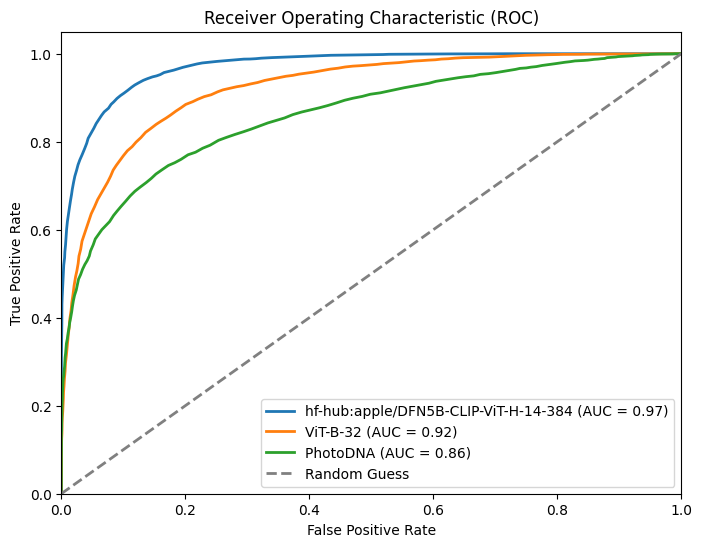

In [65]:
from sklearn.metrics import auc


plt.figure(figsize=(8, 6))
for label, results in results_curves.items():
    # Extract FPR and TPR for each threshold.
    # Note: Sorting the thresholds ensures the curve is plotted in order.
    thresholds = sorted(results.keys())

    tpr_list = np.array([results[t].recall() for t in thresholds])
    fpr_list = np.array([results[t].fpr() for t in thresholds])
    f1_scores = np.array([results[t].f1() for t in thresholds])

    print(f"Label: {label}")
    print(f"Thresholds: {len(thresholds)}")
    print(f"TPR: {len(tpr_list)}")
    print(f"FPR: {len(fpr_list)}")
    print(f"Best F1 score: {np.max(f1_scores)}")
    print(f"Best threshold: {thresholds[np.argmax(f1_scores)]}")
    
    if has_violations(fpr_list, True):
        print(f"Violations found for FPR list {label}")
    if has_violations(tpr_list, True):
        print(f"Violations found for TPR list {label}")
    
    # Calculate the area under the ROC curve.
    roc_auc = auc(fpr_list, tpr_list)
    
    plt.plot(fpr_list, tpr_list, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()